In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
device = torch.device('cpu')
print("Using device", device)
sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 05h Single Cell Dataset Benchmarker with PHATE
> Run FRED on a specified single cell dataset, using UMAP embeddings

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05h Single Cell Dataset Benchmarker with PHATE base"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 1
contrastive_loss_weight = 0
diffdist_weight = 100
num_neighbors = 5

# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField, ManifoldWithVectorFieldV2
from torch.utils.data import DataLoader
import os
from pathlib import Path
import scvelo

np_dict = np.load("../../data/treecycle.npy", allow_pickle=True)
np_dict = np_dict.tolist()
X = np_dict['X']
flow = np_dict['flow']
labels = np_dict['labels']


FileNotFoundError: [Errno 2] No such file or directory: '../../data/circle.npy'

Set sigma =  11.4772415
Computing PHATE with phate_decay=40 and self.n_neighbors=5
X is tensor([[2.9957, 0.0000, 0.0000,  ..., 1.3863, 0.6931, 1.3863],
        [3.1355, 0.6931, 1.0986,  ..., 0.6931, 0.0000, 0.6931],
        [3.3322, 0.0000, 0.6931,  ..., 1.7918, 1.7918, 0.6931],
        ...,
        [3.8501, 0.6931, 1.9459,  ..., 2.8904, 1.3863, 1.7918],
        [4.0254, 0.0000, 1.9459,  ..., 2.6391, 1.3863, 1.3863],
        [3.7612, 0.0000, 1.9459,  ..., 2.5649, 0.6931, 1.0986]])
Calculating PHATE...
  Running PHATE on 1999 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 1.49 seconds.
  Calculating optimal t...
    Automatically selected t = 14
  Calculated optimal t in 4.30 seconds.
  Calculating diffusion po

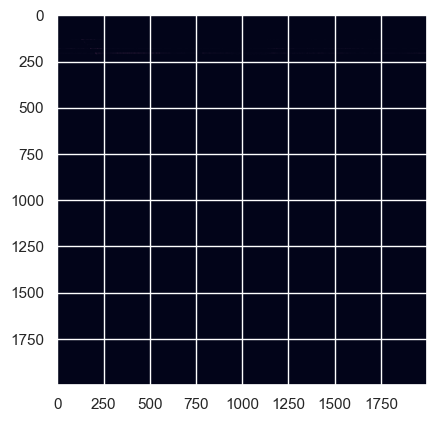

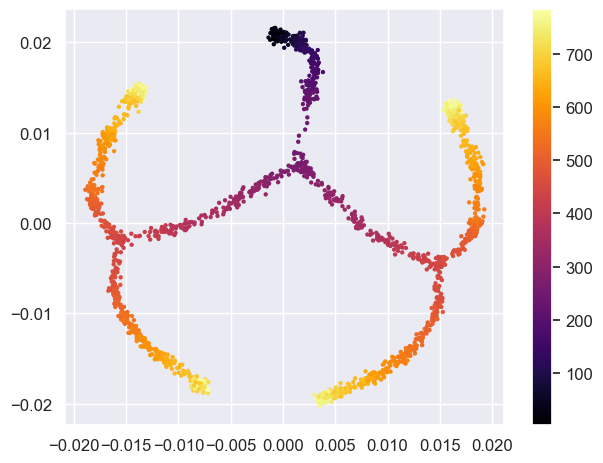

In [ ]:
# build dataset
from FRED.data_processing import ManifoldWithVectorFieldV2, FRED_collate
from functools import partial
from torch.utils.data import DataLoader

ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength, prior_embedding="PHATE", phate_gamma=0, phate_knn=50, phate_seed = 42)
# ds = ManifoldWithVectorFieldV2(X, flow, labels, sigma=sigma, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength, prior_embedding="PHATE", phate_gamma=0, phate_knn=50, phate_seed = 42)
# FRED_collate_with_dists = partial(FRED_collate,precomputed_distances = ds.precomputed_distances)
# dataloader = DataLoader(ds, batch_size=256, shuffle=True, collate_fn=FRED_collate_with_dists)
dataloader = DataLoader(ds, batch_size = None, shuffle=True)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','').replace("/","-")
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": 100,
            "kld": 0,
            "smoothness": 0,
            "flow neighbor loss": 1,
            "contrastive flow loss":1,
            "contrastive loss v2":0,
        }
visualization_functions = [
    save_embedding_visualization, # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
    visualize_points
]
FREDtrainer = Trainer(
    FE = MFE, 
    loss_weights=loss_weights, 
    visualization_functions = visualization_functions, 
    device=device, 
    title = title,
    # data_type="Contrastive Flow",
    learning_rate=1e-3,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

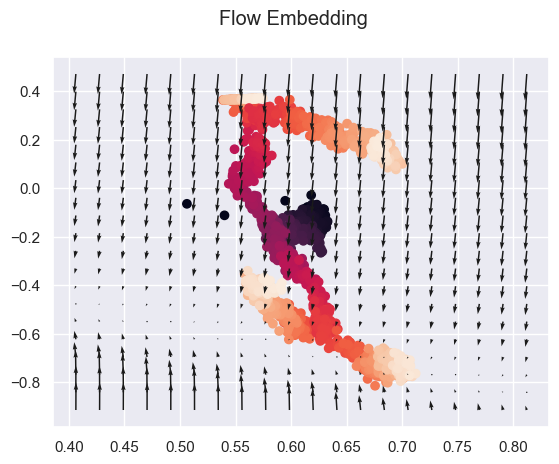

 10%|█         | 10/100 [02:06<17:55, 11.95s/it]

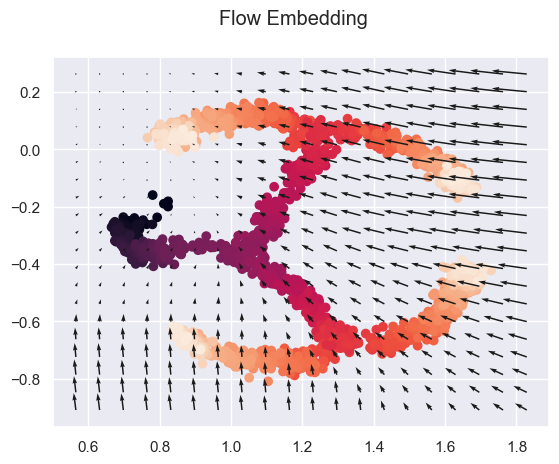

 20%|██        | 20/100 [04:11<16:50, 12.63s/it]

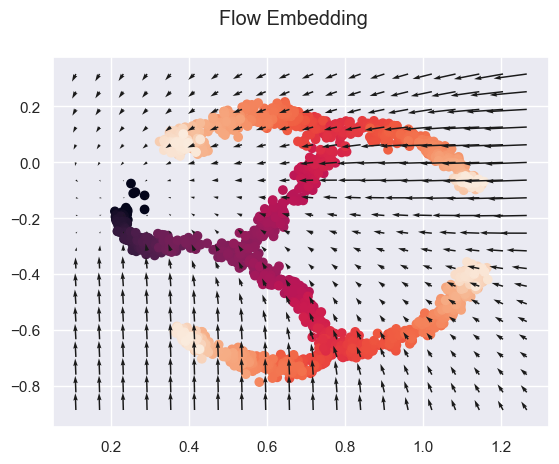

 30%|███       | 30/100 [06:18<14:08, 12.13s/it]

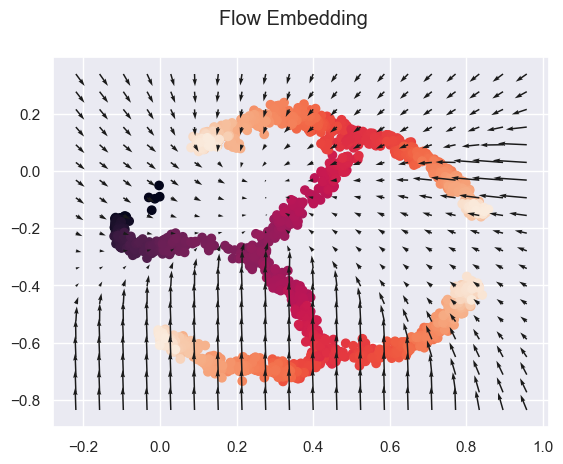

 40%|████      | 40/100 [08:23<12:19, 12.32s/it]

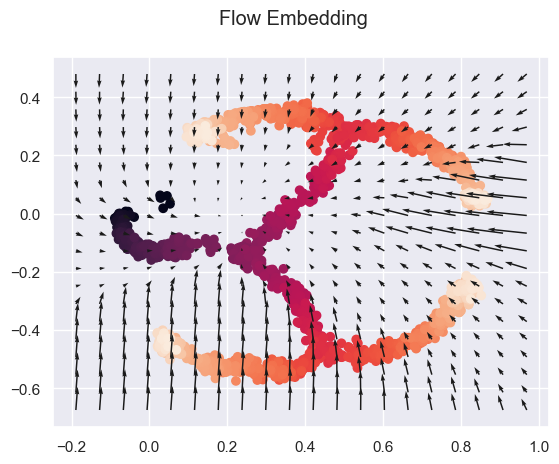

 50%|█████     | 50/100 [10:31<09:49, 11.80s/it]

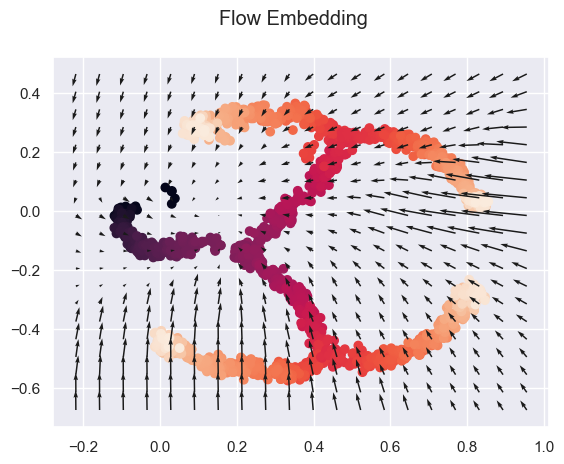

 60%|██████    | 60/100 [12:35<07:59, 11.99s/it]

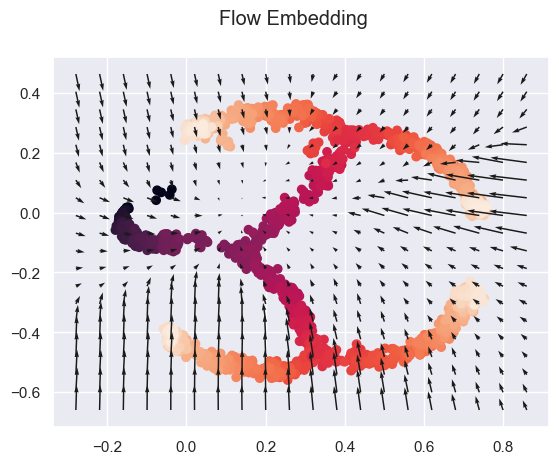

 70%|███████   | 70/100 [14:40<05:53, 11.78s/it]

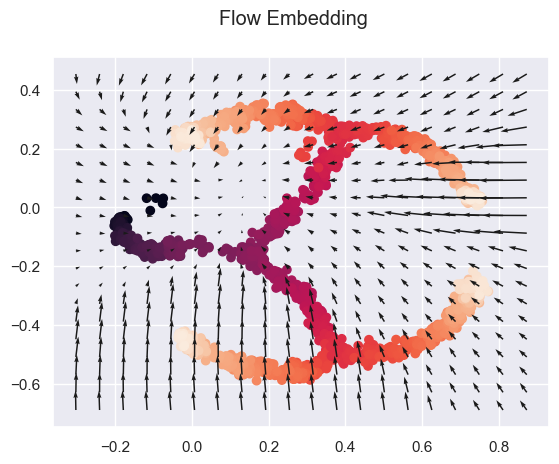

 80%|████████  | 80/100 [16:51<04:20, 13.03s/it]

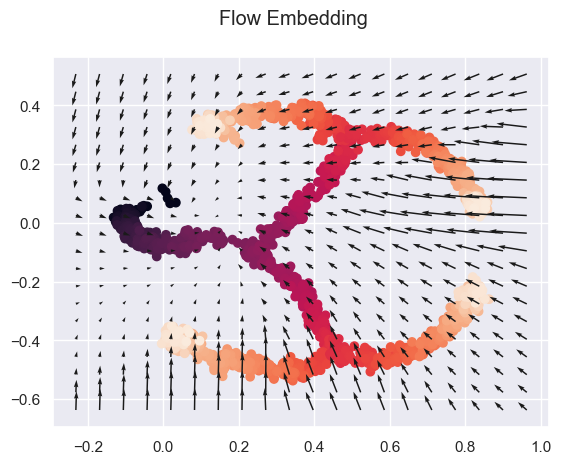

 90%|█████████ | 90/100 [18:49<01:43, 10.39s/it]

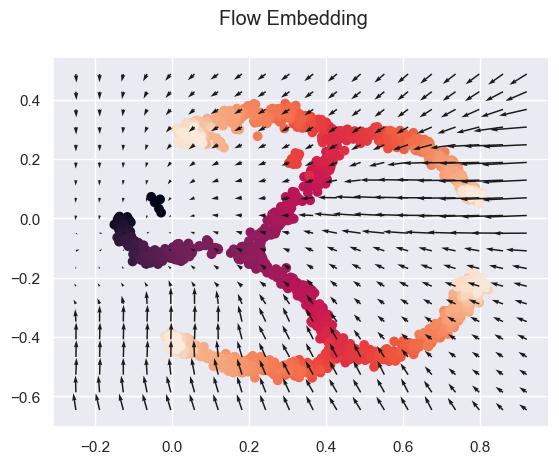

100%|██████████| 100/100 [20:37<00:00, 12.38s/it]


In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=100)

In [ ]:
torch.max(ds.precomputed_distances)

tensor(1., dtype=torch.float64)

# Results

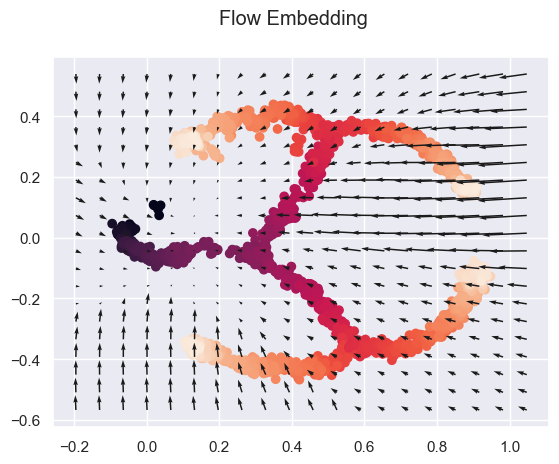

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=False)

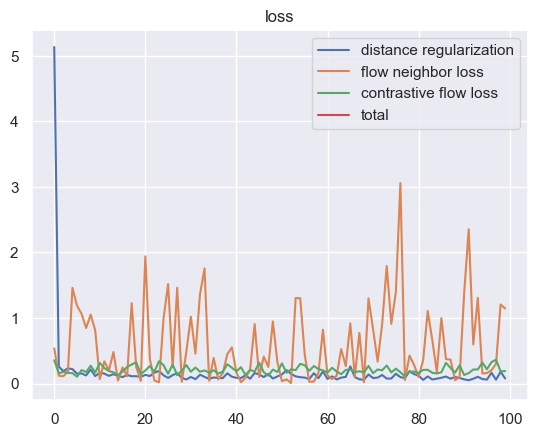

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhgALgAYcAAP///////f//+v/+///++//19f7///7/+v7+//3+//7+/v7+/P…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook.replace('/','-') + "_dataset_" + dataset_name
unid

'VoJfu3qUUmgR6ItsmOAN'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
    flow_strength = flow_strength
)
print(f"{silhouette_score=} {silhouete_score_with_flow=} {knn_score=} {neighbor_score=} {monotone_score=}")

NameError: name 'latent_time' is not defined

In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/2484851778.py", line 2, in <module>
    with open(f"results/{spread_name}.csv", 'a') as csv_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 282, in _modified_open
FileNotFoundError: [Errno 2] No such file or directory: 'results/05h Single Cell Dataset Benchmarker with PHATE base_dataset_pancreas.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-pa

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach().cpu().numpy())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/147749229.py", line 2, in <module>
    np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
                                                ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in s